In [3]:
%load_ext autoreload
%autoreload 2

# 01B-tensorflow-neural-network-regression

In [4]:
# import tensorflow
import tensorflow as tf
print(tf.__version__)

2.4.1


## Create the data

In [5]:
from src.models import PolynomialModel
import numpy as np

In [6]:
# X vals
xmin, xmax = -10, 40
m = 1000
X = np.expand_dims(np.linspace(xmin, xmax, m), axis=-1)

# Create the polymodels
polymodels = {}
polymodels['linear'] = PolynomialModel([2, 3], 5)
polymodels['quadratic'] = PolynomialModel([1, 2, -0.1], 15)

# Now sample the ys
ys = {}
ys['linear'] = polymodels['linear'](X, add_noise=True)
ys['quadratic'] = polymodels['quadratic'](X, add_noise=True)


## Draw the plots

In [7]:
import matplotlib.pyplot as plt

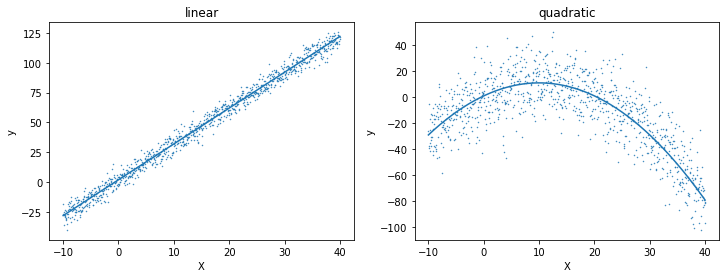

In [8]:
fig, axn = plt.subplots(1, 2, figsize=(12, 4))

for ax, modtype in zip(axn, ['linear', 'quadratic']):
    y = ys[modtype]
    polymodel = polymodels[modtype]
    
    ax.scatter(X, y, s=0.2)
    polymodel.plot(X, ax=ax, label='True Relationship')
    
    ax.set_title(modtype)
    ax.set_xlabel('X')
    ax.set_ylabel('y')

## Steps in modelling in tensorflow

1. Preparing the data to suit the initial architecture of the model
2. Creating the model: input, output layers, architecture
3. Compiling the model: loss function, optimizer (learning rate), define metrics to monitor
4. Training the model: epochs, batch_size, monitoring of train + val loss (tensorboard), callbacks, checkpoints
5. Save and Reload the model
6. Improve the model -> Iterate

### Simple Linear Regression in tensorflow

In [9]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
tfmodel = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=(1,))
])

# Compile the model
# We can choose a large enough learning rate since we know
# the relationship is truly linear
tfmodel.compile(loss=tf.keras.losses.mse, 
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), 
                metrics=['mse'])

# Summary
print(tfmodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# Fit the model
history = tfmodel.fit(X, ys['linear'], epochs=30)

Epoch 1/30
32/32 [==============================] - 1s 2ms/step - loss: 1444.5758 - mse: 1444.5758
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 37.3748 - mse: 37.3748
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 24.9163 - mse: 24.9163
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 24.7172 - mse: 24.7172
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 24.3981 - mse: 24.3981
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 24.5884 - mse: 24.5884
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 23.2999 - mse: 23.2999
Epoch 8/30
32/32 [==============================] - 0s 2ms/step - loss: 24.6750 - mse: 24.6750
Epoch 9/30
32/32 [==============================] - 0s 2ms/step - loss: 25.3463 - mse: 25.3463
Epoch 10/30
32/32 [==============================] - 0s 2ms/step - loss: 22.9681 - mse: 22.9681
Epoch 11/30
32/32 [==========================

This is the best our model can do, as our true error variability is also $5^2 = 25$ and the mse obtained is also 25!

But the keras fit output and history metrics differ? WHy?

In [11]:
history.history['mse']

[783.7576293945312,
 38.15875244140625,
 24.728683471679688,
 24.400300979614258,
 24.319063186645508,
 24.329160690307617,
 24.495691299438477,
 24.276836395263672,
 24.5329647064209,
 24.364377975463867,
 24.41558074951172,
 24.431699752807617,
 24.398983001708984,
 24.348722457885742,
 24.483898162841797,
 24.390287399291992,
 24.27345085144043,
 24.408430099487305,
 24.39280891418457,
 24.361434936523438,
 24.402328491210938,
 24.38823699951172,
 24.555147171020508,
 24.41724395751953,
 24.476558685302734,
 24.601213455200195,
 24.361215591430664,
 24.40743637084961,
 24.41730308532715,
 24.63986587524414]

In [12]:
# Prediction
y_pred = tfmodel.predict(X)

# Intercept and slope
intercept_tf, slope_tf = tfmodel.weights[1].numpy().flatten()[0], tfmodel.weights[0].numpy().flatten()[0]

# True intercept and slope
intercept, slope = polymodels['linear'].params

print(f'Intercept: True: {intercept}, Estimate: {intercept_tf}')
print(f'Slope: True: {slope}, Estimate: {slope_tf}')

Intercept: True: 2, Estimate: 2.1018707752227783
Slope: True: 3, Estimate: 2.9920992851257324


### Let's plot and compare the true and the estimated line

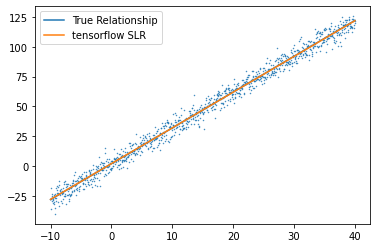

In [13]:
fig, ax = plt.subplots()

y = ys['linear']
polymodel = polymodels['linear']
tfpolymodel = PolynomialModel([intercept_tf, slope_tf], stderr=0)

ax.scatter(X, y, s=0.2)
polymodel.plot(X, ax=ax, label='True Relationship')
tfpolymodel.plot(X, ax=ax, label='tensorflow SLR') #  You can also use y_pred

plt.legend()

## Improving the model

We can improve the model by altering the steps we used in creating the model:

1. **Data Preparation**: Better feature engineering, although neural networks learn features on their own, but certain intelligent handcrafting can drastically reduce overfitting, reduce learning time and ensure the model is focussing on the right kinds of patterns, which we think maybe important.
2. **Creating the model**: Depending on how we engineer our features and hence our inputs, the input layers will change, vary the architecture, increase/decrease the layers, neurons in the layer, Add dropout, Normalization layer (if not done in data preparation)
3. **Compiling the model**: Change the optimization function (learning rate scheduling), choose metrics to monitor, engineer a loss function suited for the problem
4. **Fitting the model**: Change the number of epochs to train, batch_size, use EarlyStopping, monitor metrics/training via tensorboard, checkpoint model. Evaluate learning c urves, underfitting/overfitting and decide if we need more data or need to make the model complex or less complex or maybe even engineer new features or provide inputs in a completely different way.

## Train, test and Validation sets

1. **Training set**: model weights are learned using this set (small data - 70%, large data: 99% or even more (DL era!))
2. **Validation set**: model hyperparameters are tuned to this set (Also called **development or dev set**)
3. **Test set**: To obtain unbiased estimate of the real word performance of the model

We are aiming to acheive **Generalization** - Hmmm, debatable, how much generalization? Do we make an intelligent choice to bias our model towards a specific scenario?

## Evaluating a model

Typical workflow: Build a model -> Fit it -> evaluate it -> tweak it -> fit it -> evaluate it

When it comes to building and tweaking the model: Experiment, experiment, experiment!

When it comes to evaluation: visualize, visualize, visualize

- The data itself. EDA on the data
- The model itself - how does the model look like
- Training of the model - how is the model performing while it trains (learning curve, tensorboard, logs)
- The predictions of the model - How is model performing for different groups in the data (categorical groups, or maybe bins of a continous input). Where do the errors lie? This will help us focus on what to improve and get an idea of what kind of a data to collect (not just more data)

## Fitting a model where true relationship is polynomial (2 degree)

$y|x =  \beta_0 + \beta_1x + \beta_2x^2 + \epsilon$

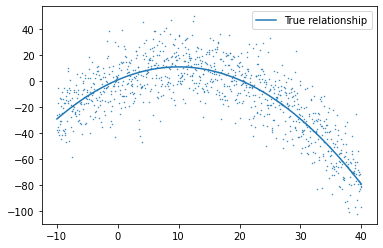

In [14]:
polymodel = polymodels['quadratic']
y = ys['quadratic']

fig, ax = plt.subplots()

ax.scatter(X, y, s=0.2)
polymodel.plot(X, ax=ax, label='True relationship')

plt.legend()

In [15]:
from sklearn.model_selection import train_test_split

# Set the seed
tf.random.set_seed(42)

# Train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Keras Experimenting

- Multiple models (Single hidden layer, Double hidden layer)
- Ways of featurizing (Polynomial feature - 2 degree)
- Experimenting with:
    - Adding more neurons
    - Change learning_rate, optimizer
    - Change epochs, batch_size

In [28]:
# dict to hold each model
tfmodels = {}

### Model 1: Single layer model (No Hidden layer)

- See effect of activation
- See effect of learning rate

In [29]:
# Set seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=['mse', 'mae'])

# Summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# Fit the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)
tfmodels['slr'] = model

In [31]:
import pandas as pd
from src.utils import get_dataframe_cols
from src.visualize import plot_learning_curve, plot1d_reg_preds

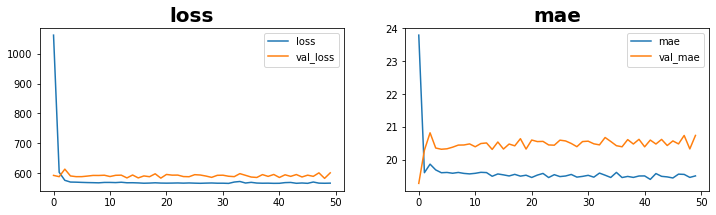

In [32]:
plot_learning_curve(history.history, extra_metric='mae');

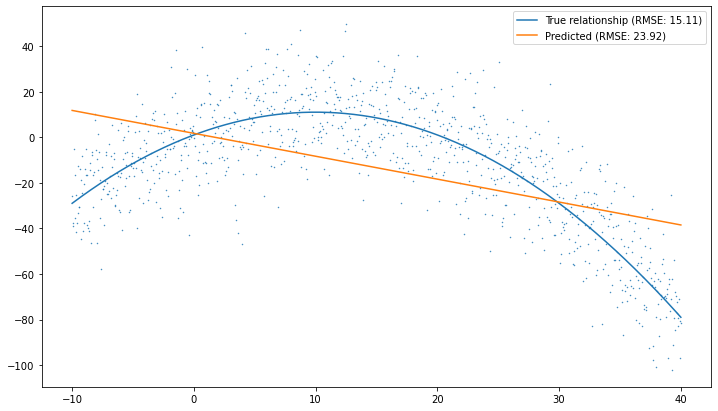

In [33]:
plot1d_reg_preds(X, y, [polymodel, model.predict], ['True relationship', 'Predicted']);

Seems like the model is highly overfitting as there is a huge difference between train and validation metrics! Long training won't really help.

## Model 2: 1 Hidden layer network

In [34]:
# set seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['mse', 'mae'])


In [35]:
# Fit the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=0)
tfmodels['single_layer'] = model

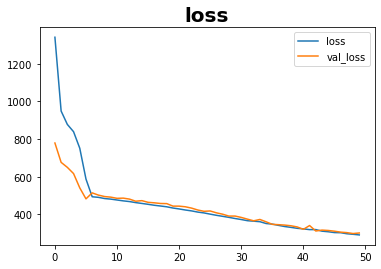

In [36]:
plot_learning_curve(history.history, include_validation=True);

(<Figure size 864x504 with 1 Axes>, <AxesSubplot:>)

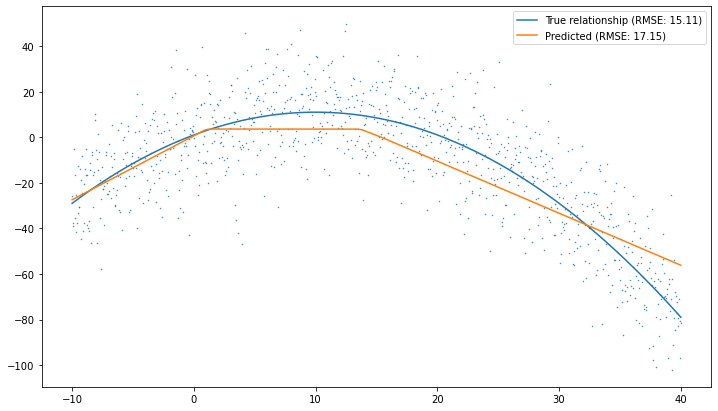

In [37]:
plot1d_reg_preds(X, y, models=[polymodel, model.predict], labels=['True relationship', 'Predicted'])

Seems like we are getting close! There still seems to be some underfitting according to the learning curve. 

### Model 3: Two hidden layers

In [38]:
# Set seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Summary
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# Fit the model
history = model.fit(X, y, validation_split=0.2, epochs=50, verbose=0)
tfmodels['double_layer'] = model

(<Figure size 432x288 with 1 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>], dtype=object))

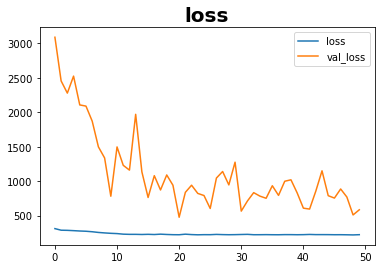

In [40]:
plot_learning_curve(history.history, include_validation=True)

(<Figure size 864x504 with 1 Axes>, <AxesSubplot:>)

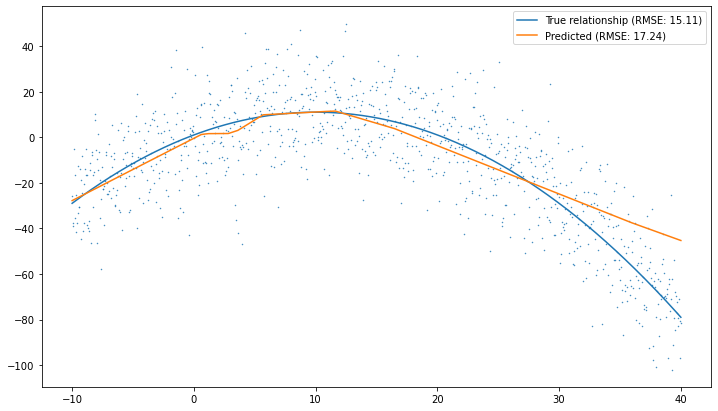

In [41]:
plot1d_reg_preds(X, y, models=[polymodel, model.predict], labels=['True relationship', 'Predicted'])

The performance of the double_layer model still seems to be about the same as the single_layer model.

### Model 4: Polynomial features - no hidden layer

**DOUBT** - Adding a scaler in the pipeline makes the model unable to learn! Scaling can have an adverse effect too!

**NOTE**:
- Need to convert sklearn preprocess pipeline to a custom Keras Layer
- This would also solve the problem of validation_split in training time. But may require more computation each iteration!

In [42]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
preprocess = Pipeline([
    ('polyfeat', PolynomialFeatures(degree=2, include_bias=False)),
#     ('scale', StandardScaler()),
])

X_train_poly = preprocess.fit_transform(X_train)
X_test_poly = preprocess.transform(X_test)

In [43]:
X_train_poly.shape

(800, 2)

In [44]:
# Set the seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Summary
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
# Fit the model
history = model.fit(X_train_poly, y_train, validation_split=0.2, epochs=50, verbose=0)
tfmodels['polyfeat'] = model

(<Figure size 432x288 with 1 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>], dtype=object))

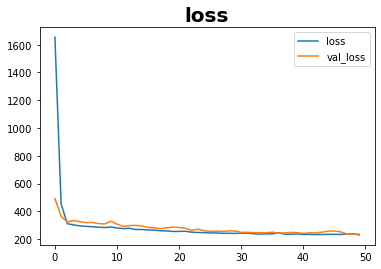

In [46]:
plot_learning_curve(history.history)

In [47]:
def predict_func_polyfeat(X):
    X = preprocess.transform(X)
    return model.predict(X)

(<Figure size 864x504 with 1 Axes>, <AxesSubplot:>)

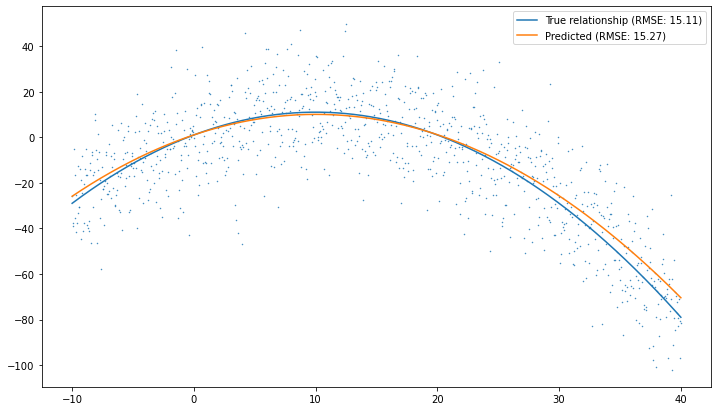

In [48]:
plot1d_reg_preds(X, y, models=[polymodel, predict_func_polyfeat], labels=['True relationship', 'Predicted'])

**Perfect!** This seems to be appropriately fitted now! We had much less parameters in this model, but due to intelligent feature engineering, we acheived much better fit in less number of epochs too!

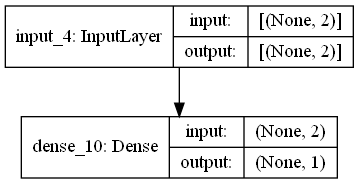

In [49]:
from src.visualize import plot_keras_model
plot_keras_model(model, show_shapes=True)

## Compare all models in a single plot!

In [50]:
tfmodels.keys()

dict_keys(['slr', 'single_layer', 'double_layer', 'polyfeat'])

(<Figure size 864x504 with 1 Axes>, <AxesSubplot:>)

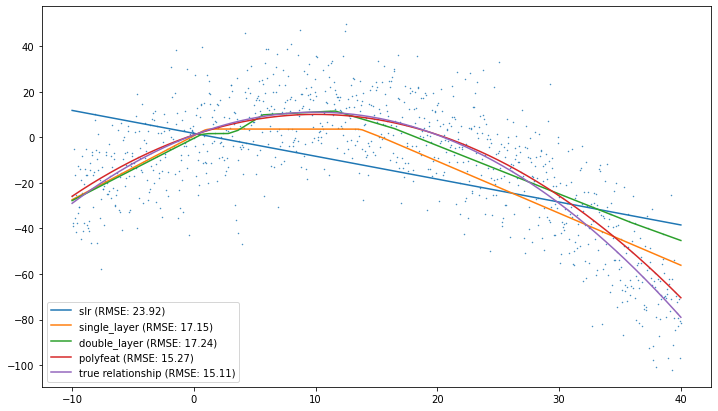

In [51]:
models = [model if name != 'polyfeat' else predict_func_polyfeat for name, model in tfmodels.items()] + [polymodel]
labels = list(tfmodels.keys()) + ['true relationship']
plot1d_reg_preds(X, y, models=models, labels=labels)

Polyfeat model performs the best and has the least amount of parameters!

## Tracking your experiments
Good Habit = Track the results of your experiments. As when doing so, it can become really tedious to track a large number of experiments.

**Resource**:

* **Tensorboard** - component of tensorflow, which helps to track modelling experiments
* **Weights & Biases** - A tool for tracking all kinds of machine learning experiments (Plugs straight into Tensorboard)

## Saving our models

Saving our models allows us to use them at other places, allow to share trained models, and also in web app!

Two main ways to save our models:

1. The SavedModel format
2. HDF5 format

In [52]:
for name, model in tfmodels.items():
    model.save(f'../models/quadratic_regression/{name}') # SavedModel format
    model.save(f'../models/quadratic_regression/{name}.h5') # HDF5 format

INFO:tensorflow:Assets written to: ../models/quadratic_regression/slr\assets
INFO:tensorflow:Assets written to: ../models/quadratic_regression/single_layer\assets
INFO:tensorflow:Assets written to: ../models/quadratic_regression/double_layer\assets
INFO:tensorflow:Assets written to: ../models/quadratic_regression/polyfeat\assets


## Loading our saved models

In [53]:
loaded_tfmodels = {name: tf.keras.models.load_model(f'../models/quadratic_regression/{name}') 
                   for name in tfmodels}

In [54]:
from src.utils import check_tfmodel_weights_equality

In [55]:
weights_equality = {name: check_tfmodel_weights_equality(tfmodels[name], loaded_tfmodels[name]) 
                    for name in tfmodels}
weights_equality

{'slr': True, 'single_layer': True, 'double_layer': True, 'polyfeat': True}

Great! All have equal weights.